In [1]:
import pandas as pd
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, average_precision_score, mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import pearsonr

import numpy as np

# preds

# Load the training set of meta-model
lipo_chemberta2_valid2 = pd.read_csv('./chemberta2/results/lipo/chemberta2_valid2_lipo_2_predictions.csv')
lipo_molformer_valid2 = pd.read_csv('./molformer/results/lipo/molformer_valid2_lipo_2.csv')
lipo_molbert_valid2 = pd.read_csv('./molbert/results/lipo/molbert_valid2_lipo_2.csv')

# Load the test data for each model
lipo_chemberta2_test = pd.read_csv('./chemberta2/results/lipo/chemberta2_test_lipo_2_predictions.csv')
lipo_molformer_test = pd.read_csv('./molformer/results/lipo/molformer_test_lipo_2.csv')
lipo_molbert_test = pd.read_csv('./molbert/results/lipo/molbert_test_lipo_2.csv')

train_mean = 2.1799722222222226
train_sd = 1.2045431891731355

# features

lipo_chemberta2_features_valid2 = pd.read_csv('./chemberta2/features/lipo/chemberta2_valid2_lipo_2_features.csv')
lipo_chemberta2_features_test = pd.read_csv('./chemberta2/features/lipo/chemberta2_test_lipo_2_features.csv')

lipo_molformer_features_valid2 = pd.read_csv('./molformer/features/lipo/molformer_valid2_lipo_2_features.csv')
lipo_molformer_features_test = pd.read_csv('./molformer/features/lipo/molformer_test_lipo_2_features.csv')

lipo_molbert_features_valid2 = pd.read_csv('./molbert/features/lipo/molbert_valid2_lipo_2_features.csv')
lipo_molbert_features_test = pd.read_csv('./molbert/features/lipo/molbert_test_lipo_2_features.csv')

For Lipo (Regression)

In [2]:
# Preparing the actual and predicted values
# Chemberta2
lipo_chemberta_actual = lipo_chemberta2_test['target']
lipo_chemberta_pred = lipo_chemberta2_test['pred_raw']

# Molformer
lipo_molformer_actual = lipo_molformer_test['target']
lipo_molformer_pred = lipo_molformer_test['pred_raw']

# molbert
lipo_molbert_actual = lipo_molbert_test['target_raw']
lipo_molbert_pred = lipo_molbert_test['pred_raw']

In [3]:
# Calculating metrics
lipo_metrics_results = {}

for model_name, actual, pred in [("Chemberta2", lipo_chemberta_actual, lipo_chemberta_pred),
                                 ("Molformer", lipo_molformer_actual, lipo_molformer_pred),
                                 ("Molbert", lipo_molbert_actual, lipo_molbert_pred)]:
    lipo_metrics_results[model_name] = {
        "MAE": mean_absolute_error(actual, pred),
        "RMSE": np.sqrt(mean_squared_error(actual, pred)),
        "R2 Score": r2_score(actual, pred),
        "Correlation": pearsonr(actual, pred)[0]  # Only record the correlation coefficient
    }

lipo_metrics_results

{'Chemberta2': {'MAE': 0.47080364152170984,
  'RMSE': 0.6194242164406615,
  'R2 Score': 0.725099924775132,
  'Correlation': 0.8597960575490352},
 'Molformer': {'MAE': 0.45518342900000003,
  'RMSE': 0.6064332745501879,
  'R2 Score': 0.7365097534650544,
  'Correlation': 0.867404233883593},
 'Molbert': {'MAE': 0.5100067769880953,
  'RMSE': 0.6507887204149233,
  'R2 Score': 0.6965560154119396,
  'Correlation': 0.8370118646634633}}

In [4]:
# Create the features for the ensemble from the prediction probabilities of being in class 1
lipo_X_ensemble_valid2 = pd.concat([
    lipo_chemberta2_valid2['pred_z'],
    lipo_molformer_valid2['pred_z'], 
    lipo_molbert_valid2['pred_z'],
    # add features from training set
    lipo_chemberta2_features_valid2.iloc[:, 2:],
    lipo_molformer_features_valid2.iloc[:, 1:],
    lipo_molbert_features_valid2.iloc[:, 1:]
], axis=1)

# change feature names of the ensemble so that they are unique
lipo_X_ensemble_valid2.columns = ['chemberta', 'molformer', 'molbert'] + list(lipo_chemberta2_features_valid2.columns[2:]) + list(lipo_molformer_features_valid2.columns[1:]) + list(lipo_molbert_features_valid2.columns[1:])

# Use the actual labels from any of the models (assuming they are all the same across datasets)
lipo_y_ensemble_valid2 = (lipo_chemberta2_valid2['target'] - train_mean) / train_sd

lipo_X_ensemble_test = pd.concat([
    lipo_chemberta2_test['pred_z'],
    lipo_molformer_test['pred_z'],  
    lipo_molbert_test['pred_z'],
    # add features from test set
    lipo_chemberta2_features_test.iloc[:, 2:],
    lipo_molformer_features_test.iloc[:, 1:],
    lipo_molbert_features_test.iloc[:, 1:]
], axis=1)

# change feature names of the ensemble so that they are unique
lipo_X_ensemble_test.columns = ['chemberta', 'molformer', 'molbert'] + list(lipo_chemberta2_features_test.columns[2:]) + list(lipo_molformer_features_test.columns[1:]) + list(lipo_molbert_features_test.columns[1:])

# Use the actual labels from any of the models (assuming they are all the same across datasets)
lipo_y_ensemble_test = lipo_chemberta2_test['target']

In [5]:
import pandas as pd
from sklearn.cross_decomposition import CCA
from itertools import combinations
from sklearn.preprocessing import StandardScaler

# Assuming bace_chemberta2_features, bace_molformer_features, bace_molbert_features are loaded

# Creating a dictionary of feature sets for easy access
feature_sets = {
    'Chemberta': lipo_chemberta2_features_valid2.iloc[:, 2:],
    'Molformer': lipo_molformer_features_valid2.iloc[:, 1:],
    'Molbert': lipo_molbert_features_valid2.iloc[:, 1:]
}

# Prepare to store results
correlation_results = []

# Initialize a scaler
scaler = StandardScaler()

# Loop through each pair of feature sets
for model1, model2 in combinations(feature_sets.keys(), 2):
    # Get the data for each model and scale it
    
    X = scaler.fit_transform(feature_sets[model1])
    Y = scaler.fit_transform(feature_sets[model2])

    # Print dimensions for debugging
    print(f"Dimensions for {model1}: {X.shape}, Dimensions for {model2}: {Y.shape}")

    # Determine the maximum number of components possible
    # n_comp = min(X.shape[0], X.shape[1], Y.shape[1])

    n_comp = 2

    # Initialize and fit CCA
    cca = CCA(n_components=n_comp)
    cca.fit(X, Y)
    
    X_c, Y_c = cca.transform(X, Y) #transform our datasests to obtain canonical variates
    
    # Calculate the canonical correlations
    # score = cca.score(X, Y)
    
    # Calculate the canonical correlations manually
    correlations = [np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(n_comp)]

    correlation_results.append([model1, model2, np.mean(correlations)])

# Optional: Convert results to DataFrame for better visualization or further analysis
results_df = pd.DataFrame(correlation_results, columns=['Model1', 'Model2', 'Mean Corr'])
print(results_df)


Dimensions for Chemberta: (840, 384), Dimensions for Molformer: (840, 768)
Dimensions for Chemberta: (840, 384), Dimensions for Molbert: (840, 768)
Dimensions for Molformer: (840, 768), Dimensions for Molbert: (840, 768)
      Model1     Model2  Mean Corr
0  Chemberta  Molformer   0.999085
1  Chemberta    Molbert   0.999205
2  Molformer    Molbert   0.955616


In [5]:
# min-max scaling using minmaxscaler
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# lipo_X_ensemble_valid2_scaled = scaler.fit_transform(lipo_X_ensemble_valid2)
# lipo_X_ensemble_test_scaled = scaler.transform(lipo_X_ensemble_test)

# # convert back to dataframe
# lipo_X_ensemble_valid2_scaled = pd.DataFrame(lipo_X_ensemble_valid2_scaled, columns=lipo_X_ensemble_valid2.columns)
# lipo_X_ensemble_test_scaled = pd.DataFrame(lipo_X_ensemble_test_scaled, columns=lipo_X_ensemble_test.columns)

In [6]:
# scale the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
lipo_X_ensemble_valid2_scaled = scaler.fit_transform(lipo_X_ensemble_valid2)
lipo_X_ensemble_test_scaled = scaler.transform(lipo_X_ensemble_test)

lipo_X_ensemble_valid2_scaled = pd.DataFrame(lipo_X_ensemble_valid2_scaled, columns=lipo_X_ensemble_valid2.columns)
lipo_X_ensemble_test_scaled = pd.DataFrame(lipo_X_ensemble_test_scaled, columns=lipo_X_ensemble_test.columns)

In [ ]:
# export lipo_X_ensemble_valid2 and lipo_y_ensemble_valid2 to csv
lipo_X_ensemble_valid2_scaled.to_csv('./processed_data/lipo_X_ensemble_valid2_scaled.csv', index=False)
lipo_X_ensemble_test_scaled.to_csv('./processed_data/lipo_X_ensemble_test_scaled.csv', index=False)

In [13]:
# lasso model
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize the LassoCV model
lasso_cv = LassoCV(cv=5, max_iter = 5000, random_state=0)

# Fit the model
lasso_cv.fit(lipo_X_ensemble_valid2_scaled, lipo_y_ensemble_valid2)

# Predict the test set
lipo_lasso_pred = lasso_cv.predict(lipo_X_ensemble_test_scaled) * train_sd + train_mean

# Calculate the metrics
lipo_lasso_metrics = {
    "MAE": mean_absolute_error(lipo_y_ensemble_test, lipo_lasso_pred),
    "RMSE": np.sqrt(mean_squared_error(lipo_y_ensemble_test, lipo_lasso_pred)),
    "R2 Score": r2_score(lipo_y_ensemble_test, lipo_lasso_pred),
    "Correlation": pearsonr(lipo_y_ensemble_test, lipo_lasso_pred)[0]
}

lipo_lasso_metrics

{'MAE': 0.4085586716424706,
 'RMSE': 0.5426676699070587,
 'R2 Score': 0.7890078022559437,
 'Correlation': 0.8894517190443607}

In [14]:
coefs = pd.Series(lasso_cv.coef_, index=lipo_X_ensemble_valid2.columns)

selected_features = coefs[coefs != 0].index.tolist()

# count the number of selected features with chemberta2, molformer, molbert, respectively
print("Selected Features:", selected_features)
print("Number of Chemberta2 Features Selected:", sum('chemberta' in feature for feature in selected_features))
print("Number of Molformer Features Selected:", sum('molformer' in feature for feature in selected_features))
print("Number of Molbert Features Selected:", sum('molbert' in feature for feature in selected_features))


Selected Features: ['chemberta', 'molformer', 'molbert', 'chemberta2_feature_7', 'chemberta2_feature_17', 'chemberta2_feature_33', 'chemberta2_feature_157', 'chemberta2_feature_182', 'chemberta2_feature_284', 'chemberta2_feature_349', 'chemberta2_feature_372', 'molformer_feature_34', 'molformer_feature_67', 'molformer_feature_112', 'molformer_feature_175', 'molformer_feature_191', 'molformer_feature_261', 'molformer_feature_277', 'molformer_feature_392', 'molformer_feature_443', 'molformer_feature_509', 'molformer_feature_510', 'molformer_feature_514', 'molformer_feature_597', 'molformer_feature_733', 'molformer_feature_734', 'molbert_features_12', 'molbert_features_28', 'molbert_features_58', 'molbert_features_123', 'molbert_features_332', 'molbert_features_341', 'molbert_features_407', 'molbert_features_455', 'molbert_features_504', 'molbert_features_588', 'molbert_features_610']
Number of Chemberta2 Features Selected: 9
Number of Molformer Features Selected: 16
Number of Molbert Fea

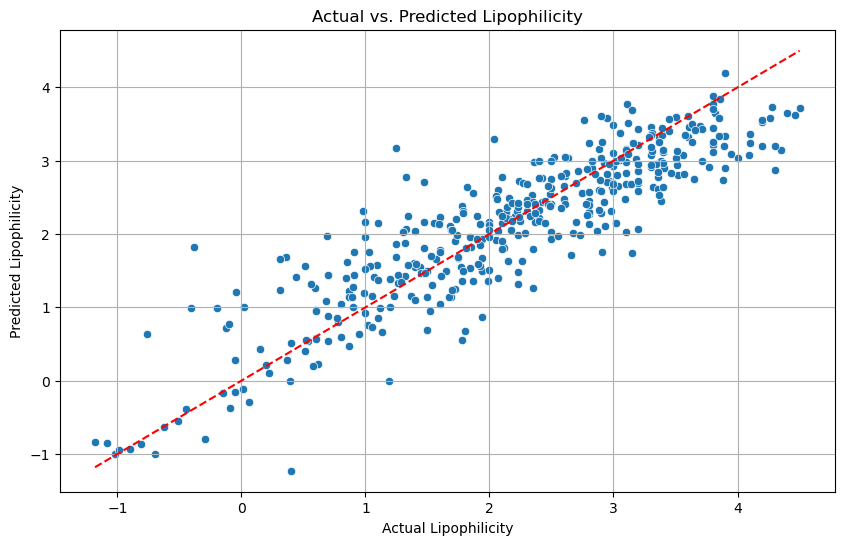

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=lipo_y_ensemble_test, y=lipo_lasso_pred)
plt.title('Actual vs. Predicted Lipophilicity')
plt.xlabel('Actual Lipophilicity')
plt.ylabel('Predicted Lipophilicity')
plt.plot([min(lipo_y_ensemble_test), max(lipo_y_ensemble_test)], [min(lipo_y_ensemble_test), max(lipo_y_ensemble_test)], color='red', linestyle='--')  # Line of perfect prediction
plt.grid(True)
plt.show()


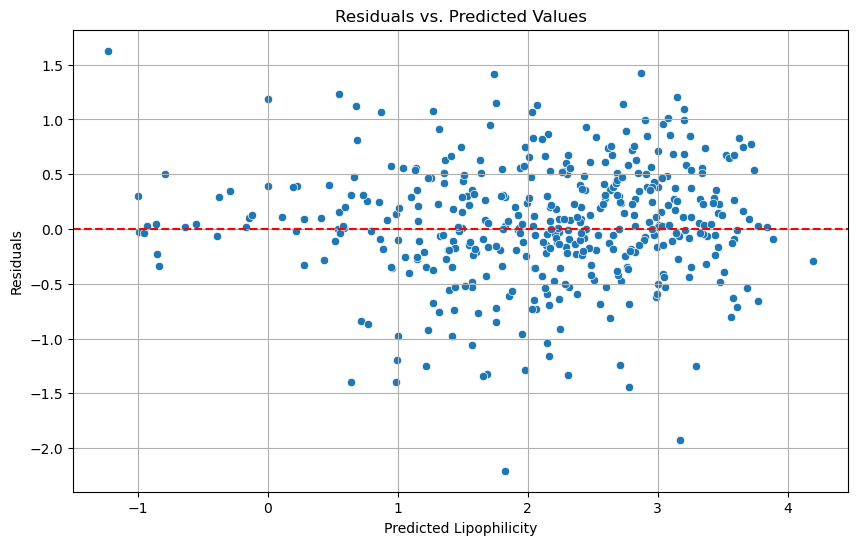

In [16]:
# Calculate residuals
residuals = lipo_y_ensemble_test - lipo_lasso_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x=lipo_lasso_pred, y=residuals)
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Lipophilicity')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.grid(True)
plt.show()


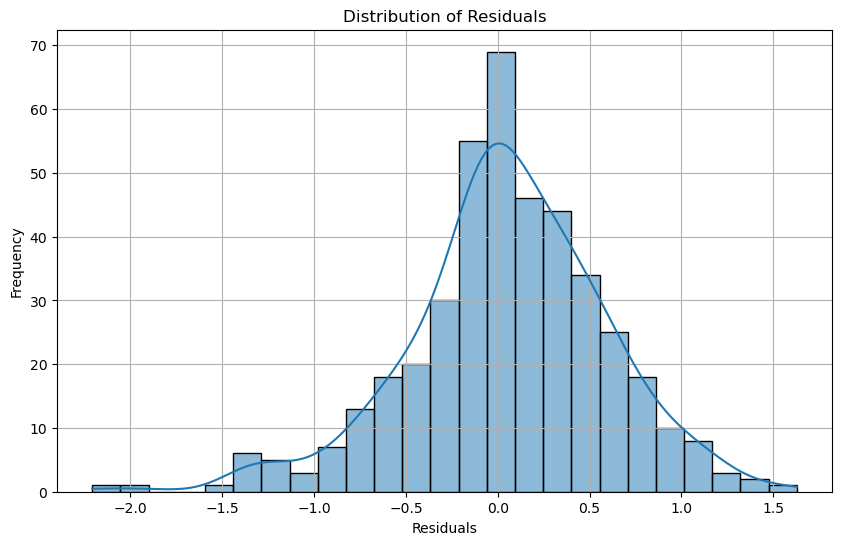

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


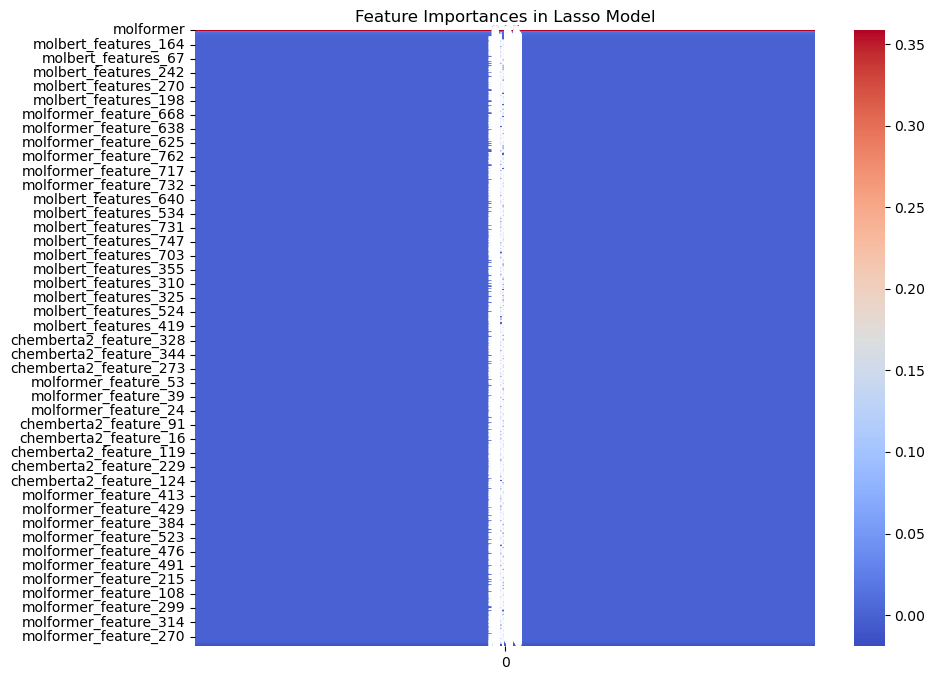

In [18]:
# Getting the coefficients
coefficients = pd.Series(lasso_cv.coef_, index=lipo_X_ensemble_valid2_scaled.columns)

plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(coefficients.sort_values(ascending=False)), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Importances in Lasso Model')
plt.show()


In [19]:
# elastic net
# Define the model with elasticnet penalty for regression
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

elastic_net_model = ElasticNet(random_state=0, max_iter=5000)

# Define the hyperparameter grid
# Use fewer discrete values for alpha and l1_ratio
alphas = [0.01, 0.1, 1, 3]  # Reduced number of points focusing on lower and mid-range
l1_ratios = [0.1, 0.5, 0.9]  # Reduced to three points, emphasizing edges and midpoint

params = {
    'alpha': alphas,  # Convert alpha back to C
    'l1_ratio': l1_ratios
}

grid_search = GridSearchCV(elastic_net_model, param_grid=params, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(lipo_X_ensemble_valid2_scaled, lipo_y_ensemble_valid2)

# Get the best hyperparameters
lipo_best_elastic_params = grid_search.best_params_
print(lipo_best_elastic_params)

# Initialize and train the best ElasticNet model
lipo_best_elastic_model = ElasticNet(alpha=lipo_best_elastic_params['alpha'], l1_ratio=lipo_best_elastic_params['l1_ratio'], random_state=0, max_iter=5000)
lipo_best_elastic_model.fit(lipo_X_ensemble_valid2_scaled, lipo_y_ensemble_valid2)

# Predict the test set
lipo_elastic_pred = lipo_best_elastic_model.predict(lipo_X_ensemble_test_scaled) * train_sd + train_mean

# Calculate the metrics
lipo_elastic_metrics = {
    "MAE": mean_absolute_error(lipo_y_ensemble_test, lipo_elastic_pred),
    "RMSE": np.sqrt(mean_squared_error(lipo_y_ensemble_test, lipo_elastic_pred)),
    "R2 Score": r2_score(lipo_y_ensemble_test, lipo_elastic_pred),
    "Correlation": pearsonr(lipo_y_ensemble_test, lipo_elastic_pred)[0]
}

lipo_elastic_metrics

{'alpha': 0.1, 'l1_ratio': 0.5}


{'MAE': 0.41719058931010194,
 'RMSE': 0.5492880957221701,
 'R2 Score': 0.7838282828133483,
 'Correlation': 0.8874373136308009}

In [30]:
# use elastic net to select features
coefs = pd.Series(lipo_best_elastic_model.coef_, index=lipo_X_ensemble_valid2.columns)

selected_features = coefs[coefs != 0].index.tolist()
lipo_X_ensemble_valid2_selected = lipo_X_ensemble_valid2[selected_features]
lipo_X_ensemble_test_selected = lipo_X_ensemble_test[selected_features]

print("Selected Features:", selected_features)
print("Filtered Dataset Shape:", lipo_X_ensemble_valid2_selected.shape)

# check how many features have Chemberta2, Molformer, Molbert
selected_features = lipo_X_ensemble_valid2_selected.columns
chemberta_count = sum('chemberta' in feature for feature in selected_features)
molformer_count = sum('molformer' in feature for feature in selected_features)
molbert_count = sum('molbert' in feature for feature in selected_features)

print("Chemberta2 count:", chemberta_count)
print("Molformer count:", molformer_count)
print("Molbert count:", molbert_count)

Selected Features: ['chemberta', 'molformer', 'molbert', 'chemberta2_feature_17', 'chemberta2_feature_182', 'chemberta2_feature_284', 'chemberta2_feature_372', 'molformer_feature_34', 'molformer_feature_261', 'molformer_feature_277', 'molformer_feature_392', 'molformer_feature_514', 'molformer_feature_597', 'molbert_features_28', 'molbert_features_332']
Filtered Dataset Shape: (840, 15)
Chemberta2 count: 5
Molformer count: 7
Molbert count: 3


In [31]:
# # use lasso to select features
# coefs = pd.Series(lasso_cv.coef_, index=lipo_X_ensemble_valid2.columns)

# selected_features = coefs[coefs != 0].index.tolist()
# lipo_X_ensemble_valid2_selected = lipo_X_ensemble_valid2[selected_features]
# lipo_X_ensemble_test_selected = lipo_X_ensemble_test[selected_features]

# print("Selected Features:", selected_features)
# print("Filtered Dataset Shape:", lipo_X_ensemble_valid2_selected.shape)

# # check how many features have Chemberta2, Molformer, Molbert
# selected_features = lipo_X_ensemble_valid2_selected.columns
# chemberta_count = sum('chemberta' in feature for feature in selected_features)
# molformer_count = sum('molformer' in feature for feature in selected_features)
# molbert_count = sum('molbert' in feature for feature in selected_features)

# print("Chemberta2 count:", chemberta_count)
# print("Molformer count:", molformer_count)
# print("Molbert count:", molbert_count)

In [32]:
lipo_X_ensemble_valid2_selected = lipo_X_ensemble_valid2_scaled[selected_features]
lipo_X_ensemble_test_selected = lipo_X_ensemble_test_scaled[selected_features]

# check shapes
print(lipo_X_ensemble_valid2_selected.shape)
print(lipo_X_ensemble_test_selected.shape)

(840, 15)
(420, 15)


In [33]:
# Initialize and train the SVR model
from sklearn.svm import SVR

lipo_svr_model = SVR()
lipo_svr_model.fit(lipo_X_ensemble_valid2_selected, lipo_y_ensemble_valid2)

# Predict the test set
lipo_svr_pred = lipo_svr_model.predict(lipo_X_ensemble_test_selected) * train_sd + train_mean

# Calculate the metrics
lipo_svr_metrics = {
    "MAE": mean_absolute_error(lipo_y_ensemble_test, lipo_svr_pred ),
    "RMSE": np.sqrt(mean_squared_error(lipo_y_ensemble_test, lipo_svr_pred )),
    "R2 Score": r2_score(lipo_y_ensemble_test, lipo_svr_pred ),
    "Correlation": pearsonr(lipo_y_ensemble_test, lipo_svr_pred )[0]  # Only record the correlation coefficient
}

lipo_svr_metrics

{'MAE': 0.44299341393305974,
 'RMSE': 0.5815363884376548,
 'R2 Score': 0.7577006280597605,
 'Correlation': 0.8708718052966318}

In [34]:
# initailize and use a 5-fold cross-validation to tune the hyperparameters of a random forest model for regression
from sklearn.ensemble import RandomForestRegressor

lipo_rf_model = RandomForestRegressor(random_state=0)

lipo_rf_model.fit(lipo_X_ensemble_valid2_selected, lipo_y_ensemble_valid2)

# Predict the test set
lipo_rf_best_pred = lipo_rf_model.predict(lipo_X_ensemble_test_selected) * train_sd + train_mean

# Calculate the metrics
lipo_rf_best_metrics = {
    "MAE": mean_absolute_error(lipo_y_ensemble_test, lipo_rf_best_pred),
    "RMSE": np.sqrt(mean_squared_error(lipo_y_ensemble_test, lipo_rf_best_pred)),
    "R2 Score": r2_score(lipo_y_ensemble_test, lipo_rf_best_pred),
    "Correlation": pearsonr(lipo_y_ensemble_test, lipo_rf_best_pred)[0]  # Only record the correlation coefficient
}

lipo_rf_best_metrics

{'MAE': 0.45084047619047624,
 'RMSE': 0.5818041117731899,
 'R2 Score': 0.7574774807921447,
 'Correlation': 0.87403362229992}

In [35]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
import numpy as np
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.early_stop import no_progress_loss

# Define the hyperparameter space using continuous distributions
lipo_xgb_hyperopt_space = {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 50),
    'max_depth': hp.quniform('max_depth', 3, 7, 2),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.3),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0)
}

# Correctly define the RMSE scorer function
def rmse_scorer(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Convert float outputs of hp.quniform to int for certain parameters
def objective(params):
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    model = xgb.XGBRegressor(**params, random_state=0)
    
    # Cross-validated RMSE as the objective
    score = cross_val_score(model, lipo_X_ensemble_valid2_selected, lipo_y_ensemble_valid2, 
                            scoring=make_scorer(rmse_scorer, greater_is_better=False), cv=5)
    
    # Minimize the positive RMSE (already negative from scoring)
    return {'loss': -score.mean(), 'status': STATUS_OK}

# Run the Bayesian optimization
trials = Trials()
lipo_xgb_best_params = fmin(fn=objective, 
                            space=lipo_xgb_hyperopt_space, 
                            algo=tpe.suggest, 
                            max_evals=100, 
                            trials=trials,
                            early_stop_fn=no_progress_loss(10))

print("Best hyperparameters:", lipo_xgb_best_params)


 27%|██▋       | 27/100 [00:15<00:42,  1.72trial/s, best loss: 0.4850130327294745] 
Best hyperparameters: {'colsample_bytree': 0.6184497318933007, 'learning_rate': 0.035499060842317916, 'max_depth': 4.0, 'n_estimators': 100.0, 'subsample': 0.9049656886385002}


In [36]:
# fit the model with the best hyperparameters
# Convert parameters obtained from Hyperopt to the correct data type
lipo_xgb_best_params['n_estimators'] = int(lipo_xgb_best_params['n_estimators'])
lipo_xgb_best_params['max_depth'] = int(lipo_xgb_best_params['max_depth'])

# Initialize and train the XGBoost model with the best parameters
lipo_xgb_model = xgb.XGBRegressor(**lipo_xgb_best_params, random_state=0)
lipo_xgb_model.fit(lipo_X_ensemble_valid2_selected, lipo_y_ensemble_valid2)

# Predict the test set
lipo_xgb_best_pred = lipo_xgb_model.predict(lipo_X_ensemble_test_selected) * train_sd + train_mean

# Calculate the metrics
lipo_xgb_best_metrics = {
    "MAE": mean_absolute_error(lipo_y_ensemble_test, lipo_xgb_best_pred),
    "RMSE": np.sqrt(mean_squared_error(lipo_y_ensemble_test, lipo_xgb_best_pred)),
    "R2 Score": r2_score(lipo_y_ensemble_test, lipo_xgb_best_pred),
    "Correlation": pearsonr(lipo_y_ensemble_test, lipo_xgb_best_pred)[0]  # Only record the correlation coefficient
}

lipo_xgb_best_metrics

{'MAE': 0.4407764026664552,
 'RMSE': 0.5678175228824743,
 'R2 Score': 0.7689978191945572,
 'Correlation': 0.8779408889007031}

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import mean_squared_error
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.early_stop import no_progress_loss

torch.manual_seed(0)

# Define RMSE loss
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))

# Define the neural network model for regression
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_layers, num_neurons, dropout_rate):
        super(SimpleNN, self).__init__()
        layers = [nn.Linear(input_size, num_neurons), nn.ReLU(), nn.Dropout(dropout_rate)]
        
        for _ in range(1, num_layers):
            layers += [nn.Linear(num_neurons, num_neurons), nn.ReLU(), nn.Dropout(dropout_rate)]
        
        layers += [nn.Linear(num_neurons, 1)]
        
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

# Hyperparameter space with hp.quniform for integer distribution
space = {
    'num_layers': hp.quniform('num_layers', 1, 5, 1),
    'num_neurons': hp.quniform('num_neurons', 16, 256, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.01)),
    'dropout_rate': hp.uniform('dropout_rate', 0.0, 0.5)
}

# Global dataset variables assumed to be defined externally
X = lipo_X_ensemble_valid2_selected
y = lipo_y_ensemble_valid2

# Objective function for Bayesian optimization
def objective(params):
    params['num_layers'] = int(params['num_layers'])  # Ensure num_layers is an integer
    params['num_neurons'] = int(params['num_neurons'])  # Ensure num_neurons is an integer
    kf = KFold(n_splits=5)
    rmse_scores = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Convert DataFrame to numpy arrays before making them PyTorch tensors
        train_dataset = TensorDataset(torch.tensor(X_train.values.astype(np.float32)), 
                                      torch.tensor(y_train.values.astype(np.float32)).unsqueeze(1))
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

        model = SimpleNN(input_size=X_train.shape[1], num_layers=params['num_layers'],
                         num_neurons=params['num_neurons'], dropout_rate=params['dropout_rate'])
        criterion = RMSELoss()
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

        model.train()
        for epoch in range(100):
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

        model.eval()
        with torch.no_grad():
            val_preds = model(torch.tensor(X_val.values.astype(np.float32))).squeeze(1)
            val_targets = torch.tensor(y_val.values.astype(np.float32))
            rmse = np.sqrt(mean_squared_error(val_targets.numpy(), val_preds.numpy()))
            rmse_scores.append(rmse)

    avg_rmse = np.mean(rmse_scores)
    return {'loss': avg_rmse, 'status': STATUS_OK} # Minimize RMSE

# Run Bayesian optimization
trials = Trials()
lipo_nn_best_params = fmin(fn=objective,
                           space=space,
                           algo=tpe.suggest,
                           max_evals=50,
                           trials=trials,
                           early_stop_fn=no_progress_loss(10))

print("Best hyperparameters:", lipo_nn_best_params)


 38%|███▊      | 19/50 [05:59<09:47, 18.95s/trial, best loss: 0.4752684235572815]
Best hyperparameters: {'dropout_rate': 0.4754042485373917, 'learning_rate': 0.0005929616930921651, 'num_layers': 1.0, 'num_neurons': 23.0}


In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

torch.manual_seed(0)

# Define the neural network model again
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_layers, num_neurons, dropout_rate):
        super(SimpleNN, self).__init__()
        layers = [nn.Linear(input_size, num_neurons), nn.ReLU(), nn.Dropout(dropout_rate)]
        
        for _ in range(1, num_layers):
            layers += [nn.Linear(num_neurons, num_neurons), nn.ReLU(), nn.Dropout(dropout_rate)]
        
        layers += [nn.Linear(num_neurons, 1)]
        
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

# Define a function to compute RMSE
def compute_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Convert parameters to the correct format if necessary
lipo_nn_best_params = {
    'num_layers':  int(lipo_nn_best_params['num_layers']),  # Extracted from Bayesian optimization results
    'num_neurons':  int(lipo_nn_best_params['num_neurons']),  # Extracted from Bayesian optimization results
    'dropout_rate': lipo_nn_best_params['dropout_rate'],  # Extracted from Bayesian optimization results
    'learning_rate': lipo_nn_best_params['learning_rate']  # Extracted from Bayesian optimization results
}

# Prepare datasets
X_train_tensor = torch.tensor(lipo_X_ensemble_valid2_selected.values.astype(np.float32))
y_train_tensor = torch.tensor(lipo_y_ensemble_valid2.values.astype(np.float32)).unsqueeze(1)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

X_test_tensor = torch.tensor(lipo_X_ensemble_test_selected.values.astype(np.float32))
y_test_tensor = torch.tensor(lipo_y_ensemble_test.values.astype(np.float32)).unsqueeze(1)

# Initialize the model
model = SimpleNN(input_size=lipo_X_ensemble_valid2_selected.shape[1], num_layers=lipo_nn_best_params['num_layers'],
                         num_neurons=lipo_nn_best_params['num_neurons'], dropout_rate=lipo_nn_best_params['dropout_rate'])
criterion = RMSELoss()
optimizer = optim.Adam(model.parameters(), lr=lipo_nn_best_params['learning_rate'])

# Training loop
model.train()
for epoch in range(100):  # Number of epochs can be adjusted
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    predictions = outputs.squeeze(1).numpy() * train_sd + train_mean

    # Calculate metrics
    mae = mean_absolute_error(y_test_tensor.numpy(), predictions)
    rmse = compute_rmse(y_test_tensor.numpy(), predictions)
    r2 = r2_score(y_test_tensor.numpy(), predictions)
    correlation, _ = pearsonr(y_test_tensor.numpy().squeeze(1), predictions)

    lipo_nn_metrics = {
        'MAE': mae,
        'RMSE': rmse,
        'R2 Score': r2,
        'Correlation': correlation
    }

lipo_nn_metrics

{'MAE': 0.42417488,
 'RMSE': 0.5570719,
 'R2 Score': 0.7776582674632766,
 'Correlation': 0.8827455389715353}

In [39]:
# create a table to record all metrics for lipo
lipo_metrics_results["Elastic Net"] = lipo_elastic_metrics
lipo_metrics_results["LASSO"] = lipo_lasso_metrics
lipo_metrics_results["SVR"] = lipo_svr_metrics
lipo_metrics_results["Random Forest"] = lipo_rf_best_metrics
lipo_metrics_results["XGBoost"] = lipo_xgb_best_metrics
lipo_metrics_results["Neural Network"] = lipo_nn_metrics

lipo_metrics_df = pd.DataFrame(lipo_metrics_results).T
# keep 3 digits after the decimal point
lipo_metrics_df = lipo_metrics_df.round(3)

# export table to csv
lipo_metrics_df.to_csv('./split2_lipo_metrics_elasticFeatures.csv')